In [1]:
import time
start_time = time.time()

In [2]:
import numpy
numpy.__version__

'1.20.3'

In [3]:
import hdbscan

In [4]:
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

In [5]:
TRX = pd.read_csv('C:\WORK\mnistTRX.csv')
VLX = pd.read_csv('C:\WORK\mnistVLX.csv')
TSX = pd.read_csv('C:\WORK\mnistTSX.csv')

TRy = pd.read_csv('C:\WORK\mnistTRy.csv')['y']
VLy = pd.read_csv('C:\WORK\mnistVLy.csv')['y']
TSy = pd.read_csv('C:\WORK\mnistTSy.csv')['y']

In [6]:
iTR = range(0, len(TRX))
iVL = range(len(TRX), len(TRX)+len(VLX))
iTS = range(len(TRX)+len(VLX), len(TRX)+len(VLX)+len(TSX))

nX = [TRX.shape, VLX.shape, TSX.shape]
ny = [TRy.shape, VLy.shape, TSy.shape]
pd.DataFrame(nX, index=['TRX', 'VLX', 'TSX'], columns=['n', 'p'])

,n,p
TRX,50000,784
VLX,10000,784
TSX,10000,784


In [7]:
# 주성분 분석
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018


%time Mpca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)


TRTpca = Mpca.fit_transform(TRX)
TRTpca = pd.DataFrame(data=TRTpca, index=iTR)

Wall time: 0 ns


# K-means

In [8]:
# K-평균
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter= 300
tol = 0.0001
random_state = 2018
n_jobs = 2

WSSkmpca = pd.DataFrame(data=[], index=range(2,21), columns=['WSS'])

for c in range(2,21):
    %time Mkmpca = KMeans(n_clusters=c, random_state=random_state)
    cutoff = 99
    Mkmpca.fit(TRTpca.loc[:, 0:cutoff])
    WSSkmpca.loc[c] = Mkmpca.inertia_

Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns


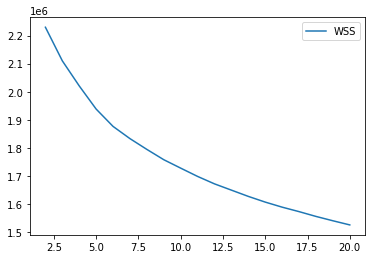

In [9]:
WSSkmpca.plot();

In [10]:
WSSkmpca

,WSS
2,2229556.378612
3,2109845.734793
4,2020530.19905
5,1938026.160249
6,1876252.916881
7,1832724.355445
8,1794333.872372
9,1757602.640879
10,1727597.512579
11,1698056.839924


In [11]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True, drop=False)
    countByCluster.columns = ['cluster', 'clusterCount']
    
    preds = pd.concat([labelsDF, clusterDF], axis=1)
    preds.columns=['trueLabel', 'cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
    
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True, drop=False)
    countMostFreq.columns = ['cluster', 'countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, left_on='cluster', right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

In [12]:
# 클러스터링 결과 평가하기
def aCluster(ch, y):
    CY = pd.crosstab(ch, y, margins=True, margins_name='Total')
    TBL = pd.concat([CY.iloc[:-1, :-1].max(axis=1), CY.iloc[:-1, :-1].idxmax(axis=1)] , axis=1)
    TBL.columns = ['ncmax', 'cmax']
    TBL= pd.merge(CY, TBL, left_index=True, right_index=True, how='left')
    TBL['acc'] = TBL.ncmax/TBL.Total
    acc = TBL.ncmax.sum()/len(ch)
    
    return TBL, acc

In [13]:
# k-means 정확도
n_clusters=5
n_init=10
max_iter=300
tol=0.0001
random_state=2018
n_jobs=2

WSSkmpca = pd.DataFrame(data=[], index=range(2,21), columns=['WSS'])
ACCkmpca = pd.DataFrame(data=[], index=range(2,21), columns=['Accuracy'])

for c in range(2,21):
    Mkmpca = KMeans(n_clusters=c, random_state=random_state)
    cutoff=99
    %time Mkmpca.fit(TRTpca.loc[:, 0:cutoff])
    WSSkmpca.loc[c] = Mkmpca.inertia_
    TRchkmpca = Mkmpca.predict(TRTpca.loc[:, 0:cutoff])
    TRchkmpca = pd.DataFrame(data=TRchkmpca, index=iTR, columns=['cluster'])
    nc, nk, ncmax, accDF, acc, cacc = analyzeCluster(TRchkmpca, TRy)
    TBL, acc = aCluster(TRchkmpca.cluster, TRy)
    ACCkmpca.loc[c]=acc

TBL

Wall time: 2.74 s
Wall time: 2.04 s
Wall time: 2.9 s
Wall time: 2.73 s
Wall time: 3.84 s
Wall time: 4.25 s
Wall time: 3.68 s
Wall time: 6.22 s
Wall time: 6.15 s
Wall time: 9.01 s
Wall time: 10.2 s
Wall time: 10.4 s
Wall time: 13.6 s
Wall time: 12.4 s
Wall time: 15.1 s
Wall time: 9.75 s
Wall time: 10.2 s
Wall time: 13.3 s
Wall time: 12.3 s


,0,1,2,3,4,5,6,7,8,9,Total,ncmax,cmax,acc
cluster,,,,,,,,,,,,,,
0,33,3,27,10,35,22,1990,2,18,4,2144,1990.0,6.0,0.928172
1,0,3091,115,114,31,34,53,72,102,28,3640,3091.0,1.0,0.849176
2,98,3,76,16,73,64,2456,0,19,2,2807,2456.0,6.0,0.874955
3,25,0,79,19,994,66,53,240,42,664,2182,994.0,4.0,0.455545
4,2,0,3,3,1449,45,2,69,52,819,2444,1449.0,4.0,0.592881
5,42,28,48,927,4,999,24,3,1338,56,3469,1338.0,8.0,0.385702
6,1487,0,24,6,2,15,47,3,7,3,1594,1487.0,0.0,0.932873
7,19,3,67,1991,0,544,6,0,108,21,2759,1991.0,3.0,0.721638
8,28,0,25,1407,0,884,16,2,449,30,2841,1407.0,3.0,0.495248


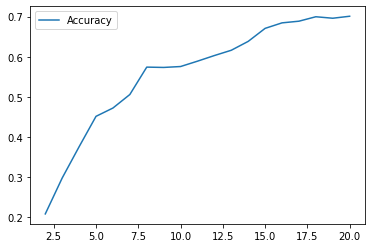

In [14]:
ACCkmpca.plot();

In [15]:
ACCkmpca

,Accuracy
2,0.20832
3,0.29786
4,0.37574
5,0.45152
6,0.4722
7,0.50588
8,0.57416
9,0.57336
10,0.57562
11,0.58896


In [16]:
n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

WSSkmpca = pd.DataFrame(data=[], index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 783], columns=['WSS'])
ACCkmpca = pd.DataFrame(data=[], index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 783], columns=['Accuracy'])

for ncomp in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    Mkmpca = KMeans(n_clusters=n_clusters, random_state=random_state)
    cutoff = ncomp
    %time Mkmpca.fit(TRTpca.loc[:, 0:cutoff])
    WSSkmpca.loc[cutoff] = Mkmpca.inertia_
    TRchkmpca = Mkmpca.predict(TRTpca.loc[:, 0:cutoff])
    TRchkmpca = pd.DataFrame(data=TRchkmpca, index=TRX.index, columns=['cluster'])
    nc, nk, ncmax, accDF, acc, cacc =  analyzeCluster(TRchkmpca, TRy)
    TBL, acc = aCluster(TRchkmpca.cluster, TRy)
    ACCkmpca.loc[cutoff] = acc
    
TBL

Wall time: 10.6 s
Wall time: 12.6 s
Wall time: 14.4 s
Wall time: 19.4 s
Wall time: 24.1 s
Wall time: 28.3 s
Wall time: 33.4 s
Wall time: 40 s
Wall time: 1min 2s
Wall time: 1min 5s


,0,1,2,3,4,5,6,7,8,9,Total,ncmax,cmax,acc
cluster,,,,,,,,,,,,,,
0,2,2473,108,25,55,14,31,103,85,21,2917,2473.0,1.0,0.847789
1,24,0,76,20,999,70,52,243,44,674,2202,999.0,4.0,0.453678
2,20,3,69,1981,0,545,7,0,108,21,2754,1981.0,3.0,0.719317
3,7,19,49,83,562,62,7,965,86,1153,2993,1153.0,9.0,0.385232
4,1,0,18,13,3,3,0,1756,1,53,1848,1756.0,7.0,0.950216
5,1665,0,7,6,1,13,28,3,10,7,1740,1665.0,0.0,0.956897
6,1287,0,32,8,0,46,45,2,16,8,1444,1287.0,0.0,0.891274
7,28,0,25,1401,0,886,16,2,449,30,2837,1401.0,3.0,0.493832
8,3,20,2126,48,1,2,21,14,18,1,2254,2126.0,2.0,0.943212


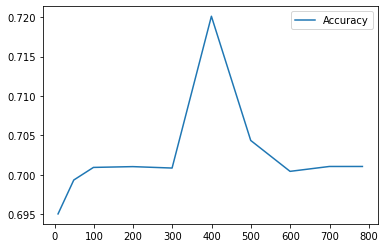

In [17]:
ACCkmpca.plot();

In [18]:
ACCkmpca

,Accuracy
9,0.69504
49,0.69934
99,0.70094
199,0.70104
299,0.70086
399,0.72012
499,0.70436
599,0.70044
699,0.70106
783,0.70106


In [19]:
n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

WSSkm = pd.DataFrame(data=[], index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 783], columns=['WSS'])
ACCkm = pd.DataFrame(data=[], index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 783], columns=['Accuracy'])

for j in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    Mkm = KMeans(n_clusters=n_clusters, random_state=random_state)
    cutoff = j
    %time Mkm.fit(TRX.iloc[:, 0:cutoff])
    WSSkm.loc[cutoff] = Mkm.inertia_
    TRchkm = Mkm.predict(TRX.iloc[:, 0:cutoff])
    TRchkm = pd.DataFrame(data=TRchkm, index=TRX.index, columns=['cluster'])
    nc, nk, ncmax, accDF, acc, cacc = analyzeCluster(TRchkm, TRy)
    TBL, acc = aCluster(TRchkm.cluster, TRy)
    ACCkm.loc[cutoff]=acc
    
TBL

<timed eval>:1: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.


Wall time: 1.07 s
Wall time: 1.8 s
Wall time: 5.41 s
Wall time: 25.8 s
Wall time: 30.6 s
Wall time: 31 s
Wall time: 53.1 s
Wall time: 49 s
Wall time: 42.4 s
Wall time: 48.5 s


,0,1,2,3,4,5,6,7,8,9,Total,ncmax,cmax,acc
cluster,,,,,,,,,,,,,,
0,2,2473,108,25,55,14,31,103,85,21,2917,2473.0,1.0,0.847789
1,24,0,76,20,999,70,52,243,44,674,2202,999.0,4.0,0.453678
2,20,3,69,1981,0,545,7,0,108,21,2754,1981.0,3.0,0.719317
3,7,19,49,83,562,62,7,965,86,1153,2993,1153.0,9.0,0.385232
4,1,0,18,13,3,3,0,1756,1,53,1848,1756.0,7.0,0.950216
5,1665,0,7,6,1,13,28,3,10,7,1740,1665.0,0.0,0.956897
6,1287,0,32,8,0,46,45,2,16,8,1444,1287.0,0.0,0.891274
7,28,0,25,1401,0,886,16,2,449,30,2837,1401.0,3.0,0.493832
8,3,20,2126,48,1,2,21,14,18,1,2254,2126.0,2.0,0.943212


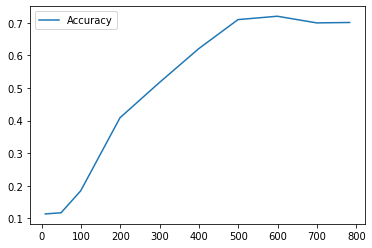

In [20]:
ACCkm.plot();

# 계층적 군집분석 hclust

In [21]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

ncomp = 99
%time L = fastcluster.linkage_vector(TRTpca.loc[:, 0:ncomp], method='ward', metric='euclidean')

Wall time: 7min 51s


In [22]:
L = pd.DataFrame(data=L, columns=['clusterOne', 'clusterTwo', 'distance', 'newClusterSize'])
L.iloc[:10]

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,0.562682,2.0
1,28350.0,37674.0,0.590866,2.0
2,26696.0,44705.0,0.621506,2.0
3,12634.0,32823.0,0.627762,2.0
4,24707.0,43151.0,0.637668,2.0
5,20465.0,24483.0,0.662557,2.0
6,466.0,42098.0,0.664189,2.0
7,46542.0,49961.0,0.665520,2.0
8,2301.0,5732.0,0.671215,2.0
9,37564.0,47668.0,0.675121,2.0


In [23]:
L.iloc[49990:]

,clusterOne,clusterTwo,distance,newClusterSize
49990,99969.0,99986.0,225.468298,8270.0
49991,99981.0,99982.0,238.845135,9750.0
49992,99968.0,99977.0,266.146782,5567.0
49993,99985.0,99989.0,270.929453,10495.0
49994,99990.0,99991.0,346.840948,18020.0
49995,99988.0,99993.0,394.365194,21567.0
49996,99987.0,99995.0,425.142387,26413.0
49997,99992.0,99994.0,440.148301,23587.0
49998,99996.0,99997.0,494.383866,50000.0


In [24]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 160
TRchfclust = fcluster(L, distance_threshold, criterion='distance')
TRchfclust = pd.DataFrame(data=TRchfclust, index=TRTpca.index, columns=['cluster'])

In [25]:
print('Number of clusters: ', len(TRchfclust['cluster'].unique()))

Number of clusters:  20


In [26]:
TBL, acc=aCluster(TRchfclust.cluster, TRy)
print('Overall accuracy from fastclust(Ward): ', acc)
TBL

Overall accuracy from fastclust(Ward):  0.76882


,0,1,2,3,4,5,6,7,8,9,Total,ncmax,cmax,acc
cluster,,,,,,,,,,,,,,
1,1149,0,1,2,1,4,3,1,1,1,1163,1149.0,0.0,0.987962
2,1209,1,2,0,0,1,12,0,1,3,1229,1209.0,0.0,0.983727
3,2427,0,5,3,1,3,8,0,2,5,2454,2427.0,0.0,0.988998
4,19,0,14,1988,0,1039,16,0,221,31,3328,1988.0,3.0,0.597356
5,2,3,7,2418,1,474,12,5,618,23,3563,2418.0,3.0,0.678642
6,44,3,50,410,10,1684,26,18,1850,86,4181,1850.0,8.0,0.442478
7,9,0,1426,8,37,1,0,1,13,6,1501,1426.0,2.0,0.950033
8,35,94,3395,202,51,23,51,98,107,39,4095,3395.0,2.0,0.829060
9,13,0,1,0,5,33,2528,0,10,0,2590,2528.0,6.0,0.976062


# DBSCAN

In [27]:
from sklearn.cluster import DBSCAN

eps = 3
min_samples = 5
leaf_size = 30
n_jobs = 4

Mdb = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, n_jobs=n_jobs)

ncomp = 99
%time TRchdb = Mdb.fit_predict(TRTpca.loc[:, 0:cutoff])
TRchdb = pd.DataFrame(data=TRchdb, index=TRX.index, columns=['cluster'])

TBL, acc = aCluster(TRchdb.cluster, TRy)
print('Overall accuracy from dbscan: ', acc)
TBL

Wall time: 2min 51s
Overall accuracy from dbscan:  0.2161


,0,1,2,3,4,5,6,7,8,9,Total,ncmax,cmax,acc
cluster,,,,,,,,,,,,,,
-1,4932,392,4968,5101,4859,4506,4929,4798,4842,4955,44282,5101.0,3.0,0.115194
0,0,5286,0,0,0,0,0,14,0,0,5300,5286.0,1.0,0.997358
1,0,0,0,0,0,0,0,215,0,0,215,215.0,7.0,1.000000
2,0,0,0,0,0,0,0,13,0,0,13,13.0,7.0,1.000000
3,0,0,0,0,0,0,0,0,0,12,12,12.0,9.0,1.000000
4,0,0,0,0,0,0,0,11,0,0,11,11.0,7.0,1.000000
5,0,0,0,0,0,0,12,0,0,0,12,12.0,6.0,1.000000
6,0,0,0,0,0,0,0,48,0,0,48,48.0,7.0,1.000000
7,0,0,0,0,0,0,5,0,0,0,5,5.0,6.0,1.000000


In [28]:
import hdbscan

min_cluster_size = 30
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'

Mhdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                      min_samples=min_samples,
                      alpha=alpha,
                      cluster_selection_method=cluster_selection_method)

ncomp = 10
%time TRchhdb = Mhdb.fit_predict(TRTpca.loc[:, 0:ncomp])
TRchhdb = pd.DataFrame(data=TRchhdb, index=TRX.index, columns=['cluster'])

TBL, acc = aCluster(TRchhdb.cluster, TRy)
print('Overall accuracy from hdbscan: ', acc)
TBL

Wall time: 25 s
Overall accuracy from hdbscan:  0.24696


,0,1,2,3,4,5,6,7,8,9,Total,ncmax,cmax,acc
cluster,,,,,,,,,,,,,,
-1,4329,566,4849,5061,4749,4254,4904,4226,4833,4799,42570,5061.0,3.0,0.118887
0,603,0,0,0,0,2,0,0,0,0,605,603.0,0.0,0.996694
1,0,0,119,0,0,0,0,0,0,0,119,119.0,2.0,1.000000
2,0,0,0,32,0,0,0,0,0,0,32,32.0,3.0,1.000000
3,0,0,0,0,0,250,0,0,2,0,252,250.0,5.0,0.992063
4,0,5112,0,7,1,0,2,9,7,2,5140,5112.0,1.0,0.994553
5,0,0,0,0,0,0,45,0,0,0,45,45.0,6.0,1.000000
6,0,0,0,0,109,0,0,0,0,186,295,186.0,9.0,0.630508
7,0,0,0,1,0,0,0,940,0,1,942,940.0,7.0,0.997877


In [29]:
print("---%s seconds ---" %(time.time()-start_time))

---1586.721854686737 seconds ---
